# ORCHIDSS Wide DDF Target Selection

In [1]:
%matplotlib inline

In [2]:
# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))


Mon May 13 09:58:31 2024

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

               numpy : 1.23.3
               scipy : 1.9.1
          matplotlib : 3.5.1
             astropy : 5.3.3
                eazy : 0.5.2.dev64
            prospect : 1.1.0


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext
from astropy.io import fits
from astropy.wcs import WCS

import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 

EAZYCODE = Users/duncan/Astro/code/eazy-py/eazy-photoz
/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/data/templates -> ./templates
/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [247]:
def calcflux(SED, wave, filt, units):
    """ Convolve synthetic SEDs with a given filter

    Arguments
    ---------
        SED : numpy.array
            Grid of synthetic spectra
        filt : '~smpy.Filter' class
            Filter through which to convolve SED grid
        z : float
            Redshift at which models are to be observed
        dl : '~astropy.units.Quantity'
            Luminosity distance corresponding to redshift(z) in given
            cosmology.
        units : '~astropy.units'
            Desired output flux units (in spectral flux density)

    Returns
    -------
        Flux : '~astropy.units.Quantity'
            Spectral flux density, with exact units as given by 'units'

    """
    # Find SED wavelength entries within filter range
    wff = np.logical_and(filt.wave[0] < wave,
                         wave < filt.wave[-1])
    wft = wave[wff]

    # Interpolate to find throughput values at new wavelength points
    tpt = griddata(filt.wave, filt.response, wft)

    # Join arrays and sort w.r.t to wf
    # Also replace units stripped by concatenate
    wf = np.array(np.concatenate((filt.wave, wft))) * u.AA
    tp = np.concatenate((filt.response, tpt))

    order = np.argsort(wf)
    wf = wf[order]
    tp = tp[order]

    # Interpolate redshifted SED and LyAbs at new wavelength points
    sed = griddata(wave, SED.T, wf).T * SED.unit
    #lyabs = griddata(wave, self.lyman_abs, wf)

    # Calculate f_nu mean
    # Integrate SED through filter, as per BC03 Fortran
    # As: f_nu=int(dnu Fnu Rnu/h*nu)/int(dnu Rnu/h*nu)
    # ie: f_nu=int(dlm Flm Rlm lm / c)/int(dlm Rlm/lm)
    top = np.trapz(sed * tp * wf /
                   c.c.to(u.AA / u.s), wf)
    bottom = np.trapz(tp / wf, wf)
    #area = (4 * np.pi * (dl ** 2))
    Flux = top / bottom #/ (1 + z) / area

    return Flux.to(units)

def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz > 0.00)
    print('NGD: {0}'.format(cut.sum()))
    dz = photoz - specz

    ol1 = (np.abs(dz)/(1+specz) > 0.2)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (np.abs(dz)/(1+specz) > 5*nmad )
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))

    print('NMAD: {0:.4f}'.format(nmad))
    print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut]/(1+specz[cut]))))
    print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut])))
    print('OLF: Def1 = {0:.4f} Def2 = {1:0.4f}'.format(OLF1, OLF2))
    print('\n')

    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return ol1_s, ol2_s, np.nanmedian(dz[ol1_s]/(1+specz[ol1_s]))



from scipy.special import erf
from scipy.special import ndtri, ndtr

from mocpy import MOC

def pbelowz(zphot, zerr, zcut):
    dz = zphot - zcut
    sigma_abs = (np.abs(dz)/zerr)

    psigma_abs = ndtr(sigma_abs)
    
    psigma = np.copy(psigma_abs)
    psigma[dz > 0.] = 1-psigma_abs[dz > 0.]
    
    return psigma


In [7]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

## Overall outline

The broad steps in the final ORCHIDSS sample selection are as follows:
1. Make photo-z selection from DESI Legacy Surveys (DR8) Photometry and associated photometric redshifts (Duncan 2022)
2. Match the sample to the MIGHTEE DR1(2) radio catalogue and perform forced photometry on the associated mosaic.
3. Perform template fitting at fixed `z_phot` to measure UVJ colours and SFR estimates for template matching to the S7 WAVES template set. (Based on sSFR and dust extinction since full WISE photometry not available).
4. Assign templates and construct 4MOST formatted catalogue for submission.

In [51]:
xmm_phot = Table.read('../InputCatalogues/optical/ls_dr8_xmm.fits')

xmm_pz = Table.read('../InputCatalogues/photoz/lsdr8_pz_xmm.fits')

xmm_merged = join(xmm_phot, xmm_pz, 
                  keys=['release', 'brickid', 'objid', 'type', 'ra', 'dec'])

In [52]:
# Calculated integrated probability below threshold redshift
wide_prob = pbelowz(xmm_merged['zphot'], 
                    xmm_merged['zphot_err'], 0.57) 

zcut = ((wide_prob > 0.80) * # High photo-z selection probability
        (xmm_merged['flag_qual'] == 1) * # Reliable redshift
        (xmm_merged['zphot'] > 0.)) # Physical redshift for any missed by above

### MIGHTEE Forced Photometry

To push the limits of the MIGHTEE data to incorporate faint SF radio sources. We perform forced photometry measurements on the positions of the optical sources within the MIGHTEE footprint. Assuming that sources are unresolved in the 8.9" image, we measure sources as the peak flux $S_{\nu, \text{1.3GHz}}$, with the noise measured from the RMS image at the source location.

To ensure accurate matches and forced photometry measurements, we first check for any systematic offset in the astrometry between the Legacy DR8 frame (GAIA DR2) and the MIGHTEE imaging.

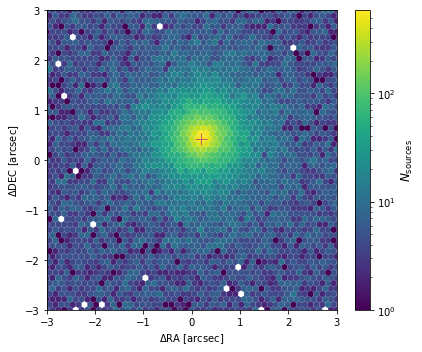

In [179]:
xmm_coord = SkyCoord(xmm_merged['ra'], xmm_merged['dec'], unit='deg')

xmm_mightee_cat = Table.read('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.gaul.fits')
mightee_coords = SkyCoord(xmm_mightee_cat['RA'], xmm_mightee_cat['DEC'], unit='deg')

idx, d2d, d3d = xmm_coord.match_to_catalog_sky(mightee_coords)

cat_match = (d2d < 1.5*u.arcsec)

# Calculate global offsets
dRA = xmm_coord.ra - mightee_coords[idx].ra
dDEC = xmm_coord.dec - mightee_coords[idx].dec

# Calculate median offset for likely matches
dRA_median = np.median(dRA[cat_match]).to(u.arcsec)
dDEC_median = np.median(dDEC[cat_match]).to(u.arcsec)

# Apply offset to LS DR8 coordinates 
xmm_coord_offset = SkyCoord(xmm_coord.ra - dRA_median, xmm_coord.dec - dDEC_median)

idxc, d2dc, d3dc = xmm_coord_offset.match_to_catalog_sky(mightee_coords)
cat_match_corr = (d2dc < 1.5*u.arcsec)

Fig, Ax = plt.subplots(1,1, figsize=(6,5))

Hx = Ax.hexbin(dRA.to(u.arcsec), dDEC.to(u.arcsec), extent=[-3, 3, -3, 3], 
          bins='log', edgecolors=None, gridsize=50)
Ax.plot(dRA_median, dDEC_median, '+', color='indianred', ms=12)
Ax.set_xlim([-3, 3])
Ax.set_ylim([-3, 3])
Ax.set_xlabel(r'$\Delta \rm{RA}$ [arcsec]')
Ax.set_ylabel(r'$\Delta \rm{DEC}$ [arcsec]')
Cb = Fig.colorbar(Hx)
Cb.set_label(r'$N_{\rm{sources}}$', size=12)
Fig.tight_layout()

In [190]:
xmm_data = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1.fits')
xmm_rms = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.rms.fits')
xmm_wcs = WCS(xmm_data[0].header, naxis=2)

xmm_img = xmm_data[0].data.squeeze()
xmm_rms_img = xmm_rms[0].data.squeeze()

# Forced phot at initial positions
xpix, ypix = xmm_wcs.world_to_array_index(xmm_coord)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < xmm_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < xmm_img.shape[0]))

flux_peak_raw = xmm_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms_raw = xmm_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr_raw = np.zeros(len(xmm_merged))
mightee_snr_raw[in_footprint] = (flux_peak_raw/flux_rms_raw)
mightee_flux_raw = np.zeros(len(xmm_merged))
mightee_flux_raw[in_footprint] = flux_peak_raw*1e6

# Forced phot with offset applied
xpix, ypix = xmm_wcs.world_to_array_index(xmm_coord_offset)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < xmm_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < xmm_img.shape[0]))

flux_peak = xmm_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms = xmm_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr = np.zeros(len(xmm_merged))
mightee_snr[in_footprint] = (flux_peak/flux_rms)
mightee_flux = np.zeros(len(xmm_merged))
mightee_flux[in_footprint] = flux_peak*1e6

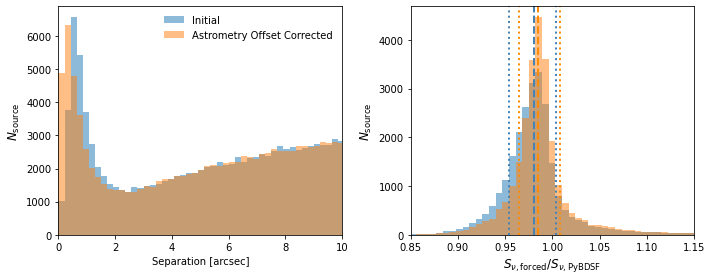

In [207]:
Fig, Ax = plt.subplots(1,2, figsize=(10, 4))

# Matching radius test
Ax[0].hist(d2d.to(u.arcsec).value, range=(0,15), bins=70, alpha=0.5, label='Initial')
Ax[0].hist(d2dc.to(u.arcsec).value, range=(0,15), bins=70, alpha=0.5, label='Astrometry Offset Corrected')
Ax[0].set_xlim([0, 10])
Ax[0].set_xlabel('Separation [arcsec]')
Ax[0].set_ylabel(r'$N_{\rm{source}}$', size=12)
Leg1 = Ax[0].legend(loc='upper right', frameon=False)

# Flux comparison - forced vs catalogue
fratio_raw = mightee_flux_raw[cat_match]/(xmm_mightee_cat['Peak_flux'][idx[cat_match]]*1e6)
fr16r, fr50r, fr84r = np.nanpercentile(fratio_raw, [16, 50, 84])

fratio = mightee_flux[cat_match_corr]/(xmm_mightee_cat['Peak_flux'][idx[cat_match_corr]]*1e6)
fr16, fr50, fr84 = np.nanpercentile(fratio, [16, 50, 84])

Ax[1].hist(fratio_raw, bins=100, range=(0.8, 1.5), alpha=0.5)
Ax[1].hist(fratio, bins=100, range=(0.8, 1.5), alpha=0.5)

ymax = Ax[1].get_ylim()[1]
Ax[1].vlines(fr50r, ymax=ymax, ymin=0., color='steelblue', ls='--', lw=2)
Ax[1].vlines([fr16r, fr84r], ymax=ymax, ymin=0., color='steelblue', ls=':', lw=2)

Ax[1].vlines(fr50, ymax=ymax, ymin=0., color='darkorange', ls='--', lw=2)
Ax[1].vlines([fr16, fr84], ymax=ymax, ymin=0., color='darkorange', ls=':', lw=2)

Ax[1].set_ylim([0, ymax])
Ax[1].set_xlim([0.85, 1.15])
Ax[1].set_xlabel(r'$S_{\nu, \rm{forced}} / S_{\nu, \rm{PyBDSF}}$', size=12)
Ax[1].set_ylabel(r'$N_{\rm{source}}$', size=12)

Fig.tight_layout()

In [226]:
mag_z_mw = 23.9 - 2.5*np.log10((xmm_merged['flux_z']*nanomaggy_to_ujy)/xmm_merged['mw_transmission_z'])

mightee_forced = (mightee_snr > 3)*(mightee_flux > 15)
mightee_catalogue = cat_match_corr * (xmm_mightee_cat['Total_flux'][idxc]*1e6 > 15)
mightee_selection = np.logical_or(mightee_forced, cat_match_corr)

print(f"MIGHTEE Catalogue Gaussians not picked up in forced photometry: {(mightee_catalogue * np.invert(mightee_forced) * zcut).sum()}" )
print(f"MIGHTEE Forced photometry sources not in PyBDSF catalogue: {(mightee_forced * np.invert(cat_match_corr) * zcut).sum()}" )

orchidss_selection = mightee_selection * zcut * (mag_z_mw < 24.)

print(f"Total sample: {orchidss_selection.sum()}")

MIGHTEE Catalogue Gaussians not picked up in forced photometry: 200
MIGHTEE Forced photometry sources not in PyBDSF catalogue: 10466
Total sample: 22798


## Template assignment

In [227]:
nanomaggy_to_ujy = 10 ** ((23.9 - 22.5) / 2.5)

filters = [col.split('_')[1] for col in xmm_merged.colnames if 
           col.startswith('flux_') and col.find('ivar') == -1]
print(filters)

xmm_eazy_input = xmm_merged[['id', 'ra', 'dec', 'type']].copy()

for filt in filters:
    xmm_eazy_input[f'flux_{filt}'] = ((xmm_merged[f'flux_{filt}'] * nanomaggy_to_ujy) / 
                                      xmm_merged[f'mw_transmission_{filt}'])
    xmm_eazy_input[f'fluxerr_{filt}'] = (((1/np.sqrt(xmm_merged[f'flux_ivar_{filt}'])) * nanomaggy_to_ujy) / 
                                         xmm_merged[f'mw_transmission_{filt}'])
    

xmm_eazy_input['z_spec'] = xmm_merged['zphot'] # Fix redshift to GPz zphot

xmm_eazy_input = xmm_eazy_input[orchidss_selection]

xmm_eazy_input.write('eazy_input/lsdr8_pz_xmm_eazy_input.cat', 
                     format='ascii.commented_header', overwrite=True)

['g', 'r', 'z', 'w1', 'w2', 'w3', 'w4']


In [228]:
template_sets = ['templates/sfhz/corr_sfhz_13.param']

pzruns = []

for i, templates in enumerate(template_sets[:]):
    params = {}
    params['CATALOG_FILE'] = 'eazy_input/lsdr8_pz_xmm_eazy_input.cat'

    params['MAIN_OUTPUT_FILE'] = 'owide_tempfit'

    # Galactic extinction
    params['MW_EBV'] = 0.00
    params['CAT_HAS_EXTCORR'] = True

    params['Z_STEP'] = 0.01
    params['Z_MIN'] = 0.0
    params['Z_MAX'] = 0.6
    params['Z_STEP_TYPE'] = 0

    params['SYS_ERR'] = 0.05
    params['APPLY_PRIOR'] = 'N'
    params['PRIOR_FILTER'] = 380
    params['PRIOR_ABZP'] = 23.9 
    params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

    params['TEMPLATES_FILE'] = os.path.join('/', os.getenv('EAZYCODE'), templates)
    params['FIX_ZSPEC'] = True

    params['IGM_SCALE_TAU'] = 1.0

    translate_file = os.path.join(os.getenv('EAZYCODE'), 'inputs/zphot.translate')


    translate = Table()
    translate['filt'] = ['id', 'z_spec'] + [col for col in xmm_eazy_input.colnames if col.startswith('flux')][:-4]


    translate['num'] = ['id', 'z_spec',
                        'F294', 'E294',
                        'F295', 'E295',
                        'F297', 'E297',
                        'F244', 'E244',
                        'F245', 'E245',
                       ]

    translate_file = os.path.join('/', os.getenv('EAZYCODE'), 'inputs/zphot.translate')

    translate.write(translate_file, format='ascii.no_header', overwrite=True)
    
    pzfit = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                               zeropoint_file=None, 
                               params=params, 
                               load_prior=True, load_products=False)

    # Turn off error corrections derived above
    pzfit.set_sys_err(positive=True)

    # fit_parallel renamed to fit_catalog 14 May 2021
    pzfit.fit_catalog(pzfit.idx, n_proc=12)
    
    pzruns.append(pzfit)

Read default param file: /Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: eazy_input/lsdr8_pz_xmm_eazy_input.cat
   >>> NOBJ = 22798
flux_g fluxerr_g (294): DECam/DECam_g.txt
flux_r fluxerr_r (295): DECam/DECam_r.txt
flux_z fluxerr_z (297): DECam/DECam_z.txt
flux_w1 fluxerr_w1 (244): WISE/RSR-W1.txt
flux_w2 fluxerr_w2 (245): WISE/RSR-W2.txt
Set sys_err = 0.05 (positive=True)
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Template grid: /Users/duncan/Astro/code/eazy-py/eazy-photoz/templates/sfhz/corr_sfhz_13.param (this may take some time)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.87it/s]


Template   0: corr_sfhz_13_bin0_av0.01.fits (NZ=14).
Template   1: corr_sfhz_13_bin0_av0.25.fits (NZ=14).
Template   2: corr_sfhz_13_bin0_av0.50.fits (NZ=14).
Template   3: corr_sfhz_13_bin0_av1.00.fits (NZ=14).
Template   4: corr_sfhz_13_bin1_av0.01.fits (NZ=14).
Template   5: corr_sfhz_13_bin1_av0.25.fits (NZ=14).
Template   6: corr_sfhz_13_bin1_av0.50.fits (NZ=14).
Template   7: corr_sfhz_13_bin1_av1.00.fits (NZ=14).
Template   8: corr_sfhz_13_bin2_av0.01.fits (NZ=14).
Template   9: corr_sfhz_13_bin2_av0.50.fits (NZ=14).
Template  10: corr_sfhz_13_bin2_av1.00.fits (NZ=14).
Template  11: corr_sfhz_13_bin3_av0.01.fits (NZ=14).
Template  12: corr_sfhz_13_bin3_av0.50.fits (NZ=14).
Process templates: 3.988 s


60it [00:00, 670.92it/s]

Set sys_err = 0.05 (positive=True)



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.40it/s]


Compute best fits
fit_best: 3.2 s (n_proc=2,  NOBJ=22798)
Fit 14.8 s (n_proc=10, NOBJ=22798)


In [318]:
from astropy.cosmology import FlatLambdaCDM
from mocpy import MOC

cos = FlatLambdaCDM(H0=70, Om0=0.3)

templist = Table.read('../ETC_Templates/S7_temps_FINAL/S7_temps_FINALprops.csv')
templist = templist[templist['veldisp'] == 45]

sps_fit = pzfit.sps_parameters(cosmology=cos, extra_rf_filters=[], percentile_limits=[16, 50, 84], n_proc=8)

cat_ssfr = np.log10(sps_fit['sfr']/sps_fit['mass'])
cat_av = sps_fit['Av']

temp_ssfr = np.log10(templist['SFR']/10**(templist['logmstar']))
temp_av = templist['tau_screen'] * 1.0857

  0%|                                                                                                         | 0/3 [00:00<?, ?it/s]/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/photoz.py:6121: RuntimeWarning: covariance is not positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],
/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/photoz.py:6121: RuntimeWarning: covariance is not positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.00s/it]


 ... rest-frame flux: 39.1 s (n_proc=3,  NOBJ=22798)


In [319]:
cat_uv = -2.5*np.log10(sps_fit['restU']/sps_fit['restV'])
cat_ub = -2.5*np.log10(sps_fit['restU']/sps_fit['restB'])
cat_bv = -2.5*np.log10(sps_fit['restB']/sps_fit['restV'])

In [320]:
from dustmaps.config import config
config.reset()
from dustmaps.sfd import SFDQuery

xmm_sample = xmm_merged[orchidss_selection]

extent = np.zeros(len(xmm_sample), dtype='int')
extent_index = np.zeros(len(xmm_sample))
extent_parameter = np.zeros(len(xmm_sample))

# DeV
dev = (xmm_sample['type'] == 'DEV')
extent[dev] = 2
extent_index[dev] = 4.0
extent_parameter[dev] = xmm_sample['shapedev_r'][dev]

# EXP
exp = ((xmm_sample['type'] == 'EXP') + (xmm_sample['type'] == 'REX') + (xmm_sample['type'] == 'COMP'))
extent[exp] = 2
extent_index[exp] = 1.0
extent_parameter[exp] = xmm_sample['shapeexp_r'][exp]


In [321]:
import smpy.smpy as S
from scipy.interpolate import griddata
import astropy.constants as c
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

filtset = S.LoadEAZYFilters('FILTER.RES.latest')

filters = S.FilterSet()
filters.addEAZYFilter(filtset, [152, 153, 154, 160])

templist = Table.read('../ETC_Templates/S7_temps_FINAL/S7_temps_FINALprops.csv')
templist = templist[templist['veldisp'] == 45]

temp_seds = []

for i, tempName in enumerate(tqdm(templist["tempName"][:])):
    temp = Table.read(f'../ETC_Templates/S7_temps_FINAL/{tempName}.fits')
    
    if i == 0:
        temp_lambda = temp["LAMBDA"]
        
    temp_seds.append(temp["FLUX_DENSITY"])

temp_seds = np.array(temp_seds)*temp_seds[0].unit

temp_fluxes = []
for filt in filters.filters[:-1]:
    fluxes = calcflux(temp_seds, temp_lambda, filt, units=u.uJy)
    temp_fluxes.append(fluxes)
    
temp_fluxes = np.array(temp_fluxes)*u.uJy

temp_ub = -2.5*np.log10(temp_fluxes[0]/temp_fluxes[1])
temp_bv = -2.5*np.log10(temp_fluxes[1]/temp_fluxes[2])
temp_uv = -2.5*np.log10(temp_fluxes[0]/temp_fluxes[2])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:02<00:00, 171.31it/s]


In [322]:
X = np.array([temp_ssfr, temp_ub, temp_bv]).T
X[np.isinf(X)] = -100 
y = np.arange(len(temp_ssfr))

x_in = np.array([cat_ssfr, cat_ub, cat_bv]).T

x_in[x_in[:,0] < -13, 0] = -16.
for i in range(3):
    x_in[np.isinf(x_in[:,i]), i] = np.nanmedian(x_in[:,i])
    x_in[np.isnan(x_in[:,i]), i] = np.nanmedian(x_in[:,i])

knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

temp_match = knn.predict(x_in)

/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


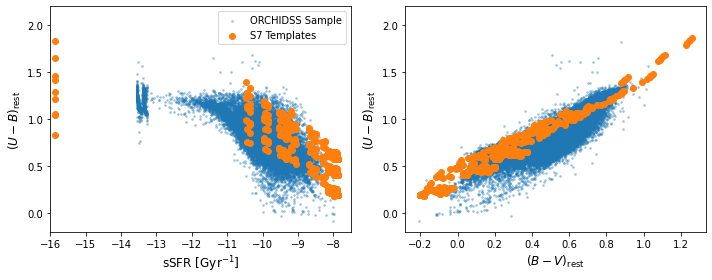

In [328]:
Fig, Ax = plt.subplots(1, 2, figsize=(10, 4))
Ax[0].scatter(cat_ssfr, cat_ub,s=3, alpha=0.3, label='ORCHIDSS Sample')
Ax[0].scatter(temp_ssfr, temp_ub, label='S7 Templates')
Ax[0].set_xlim([-16, -7.5])
Ax[0].set_ylim([-0.2, 2.2])
Ax[0].set_xlabel(r'sSFR [Gyr$^{-1}$]', size=12)
Ax[0].set_ylabel(r'$(U-B)_{\rm{rest}}$', size=12)

Leg = Ax[0].legend(loc='upper right')

Ax[1].scatter(cat_bv, cat_ub, s=3, alpha=0.3)
Ax[1].scatter(temp_bv, temp_ub)
Ax[1].set_ylabel(r'$(U-B)_{\rm{rest}}$', size=12)
Ax[1].set_xlabel(r'$(B-V)_{\rm{rest}}$', size=12)
Ax[1].set_ylim([-0.2, 2.2])

Fig.tight_layout()

In [329]:
name = np.array(['DDF2_'+str(idn) for idn in xmm_sample['id']])

orchidsswide_xmm = Table()
orchidsswide_xmm['NAME'] = name
orchidsswide_xmm['RA'] = xmm_sample['ra']
orchidsswide_xmm['DEC'] = xmm_sample['dec']
orchidsswide_xmm['MAG'] = 22.5 - 2.5*np.log10(xmm_sample['flux_r'])
orchidsswide_xmm['MAG_ERR'] = 2.5*np.log10(np.e) * 1/(xmm_sample['flux_r']*np.sqrt(xmm_sample['flux_ivar_r']))
orchidsswide_xmm['MAG_TYPE'] = 'DECam_r_AB'
orchidsswide_xmm['REDSHIFT_ESTIMATE'] = xmm_sample['zphot']
orchidsswide_xmm['REDSHIFT_ERROR'] = xmm_sample['zphot_err']

orchidsswide_xmm['EXTENT_FLAG'] = extent
orchidsswide_xmm['EXTENT_INDEX'] = extent_index
orchidsswide_xmm['EXTENT_PARAMETER'] = extent_parameter

orchidsswide_xmm['flux_g'] = xmm_sample['flux_g']*3.631
orchidsswide_xmm['fluxerr_g'] = 1/np.sqrt(xmm_sample['flux_ivar_g'])*3.631

orchidsswide_xmm['flux_r'] = xmm_sample['flux_r']*3.631
orchidsswide_xmm['fluxerr_r'] = 1/np.sqrt(xmm_sample['flux_ivar_r'])*3.631

orchidsswide_xmm['flux_z'] = xmm_sample['flux_z']*3.631
orchidsswide_xmm['fluxerr_z'] = 1/np.sqrt(xmm_sample['flux_ivar_z'])*3.631

orchidsswide_xmm['flux_w1'] = xmm_sample['flux_w1']*3.631
orchidsswide_xmm['fluxerr_w1'] = 1/np.sqrt(xmm_sample['flux_ivar_w1'])*3.631

orchidsswide_xmm['flux_w2'] = xmm_sample['flux_w2']*3.631
orchidsswide_xmm['fluxerr_w2'] = 1/np.sqrt(xmm_sample['flux_ivar_w2'])*3.631

scoord = SkyCoord(orchidsswide_xmm['RA']*u.deg, orchidsswide_xmm['DEC']*u.deg)

sfd = SFDQuery()
ebv = sfd(scoord)

orchidsswide_xmm['REDDENING'] = ebv

orchidsswide_xmm['TEMPLATE'] = templist['tempName'][temp_match]
orchidsswide_xmm['FIELD'] = 'WD02'

orchidsswide_xmm.write('../TargetCatalogues/ORCHIDSSwide-ddf_WD02_20240513.fits', 
                       format='fits', overwrite=True)

sps_fit['NAME'] = name
sps_fit['id'] = xmm_sample['id']
sps_fit['zphot'] = xmm_sample['zphot']
sps_fit['zphot_err'] = xmm_sample['zphot_err']

sps_fit.meta['TEMPLATES_FILE'] = os.path.split(sps_fit.meta['TEMPLATES_FILE'])[1]

sps_fit.write('../TargetCatalogues/ORCHIDSSwide-ddf_WD02_20240513_sps_outputs.fits', 
              format='fits', overwrite=True)

In [574]:
rf_tempfilt, lc_rect, rf_fluxes = rest_output

rf_fluxes_m50 = rf_fluxes[:, :, 2]

uv_col =  -2.5*np.log10(rf_fluxes_m50[:, 0]/rf_fluxes_m50[:, 2])
vj_col =  -2.5*np.log10(rf_fluxes_m50[:, 2]/rf_fluxes_m50[:, 3])

passive = (uv_col > (0.88*vj_col + 0.79)) * (uv_col > 1.3) * (vj_col < 1.6)

Mb = 23.9 - 2.5*np.log10(rf_fluxes_m50[:, 1]) - (cos.distmod(xmm_eazy_input['z_spec']).value -2.5*(np.log10(1+xmm_eazy_input['z_spec'])))
Mb_st_z = -21 + -1.03*(xmm_eazy_input['z_spec'] - 0.5)

In [612]:
wide_prob = pbelowz(xmm_merged['zphot'], xmm_merged['zphot_err'], 0.57)

cut = (wide_prob > 0.80) * (xmm_merged['flag_qual'] == 1) * (xmm_merged['zphot'] > 0.) * in_mightee

dM = 0.7
Mb_cut = Mb < Mb_st_z +dM

mag_r = 23.9 - 2.5*np.log10(xmm_merged['flux_r']*nanomaggy_to_ujy)
mag_r_mw = 23.9 - 2.5*np.log10(xmm_eazy_input['flux_r'])
mag_z_mw = 23.9 - 2.5*np.log10(xmm_eazy_input['flux_z'])

optical_selection = np.logical_or(Mb_cut, mag_r_mw < 20.) *np.invert(passive)* cut
waves_cut = (mag_z_mw < 21.) * cut

mightee_selection = (mightee_snr > 4)*(mightee_flux > 15) * cut * (mag_z_mw < 23.5)
mightee_blind_selection = (mightee_snr > 5)*(mightee_flux > 15) * cut

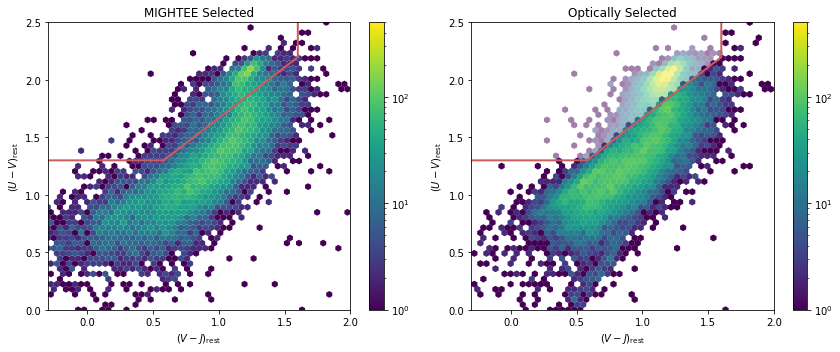

In [632]:
Fig, Ax = plt.subplots(1, 2, figsize=(12,5))
Hx1= Ax[0].hexbin(vj_col[mightee_selection], uv_col[mightee_selection], 
          bins='log', extent=[-0.3, 2.0, 0, 2.5], gridsize=50, edgecolor=None, vmin=1, vmax=500)
#Ax.plot(vj_col[passive*cut*Mb_cut], uv_col[passive*cut*Mb_cut], 'o', color='indianred', ms=1, alpha=0.1)
Ax[0].set_xlim([0, 2.])
Ax[0].set_ylim([0, 2.5])
Ax[0].set_title('MIGHTEE Selected')
Cb1 = Fig.colorbar(Hx1, ax=Ax[0])

Ax[0]
Hx2 = Ax[1].hexbin(vj_col[cut*Mb_cut], uv_col[cut*Mb_cut], 
             bins='log', extent=[-0.3, 2.0, 0, 2.5], gridsize=50, edgecolor=None, vmin=1, vmax=500, alpha=0.5)
Hx2 = Ax[1].hexbin(vj_col[optical_selection], uv_col[optical_selection], 
             bins='log', extent=[-0.3, 2.0, 0, 2.5], gridsize=50, edgecolor=None, vmin=1, vmax=500)

#Ax[1].plot(vj_col[passive*cut*Mb_cut], uv_col[passive*cut*Mb_cut], 'o', color='indianred', ms=1, alpha=0.1)

Ax[1].set_title('Optically Selected')
Cb2 = Fig.colorbar(Hx2, ax=Ax[1])

for ax in Ax:
    ax.set_xlim([-0.3, 2.])
    ax.set_ylim([0, 2.5])
    ax.set_xlabel(r'$(V-J)_{\rm{rest}}$')
    ax.set_ylabel(r'$(U-V)_{\rm{rest}}$')
    ax.plot([-0.5, 0.58, 1.6, 1.6], [1.3, 1.3, 2.198, 2.5], color='indianred', lw=2)

Fig.tight_layout()
Fig.savefig('orchidss_wide_UVJ_comparison.pdf')

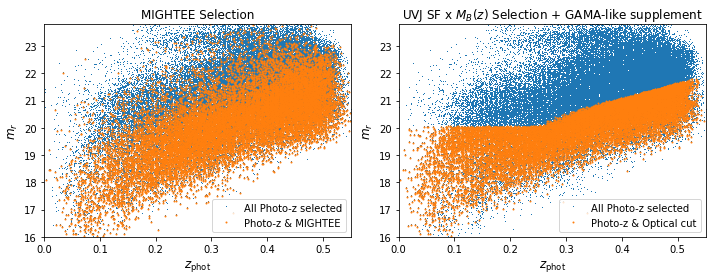

In [629]:
Fig, Ax = plt.subplots(1,2,figsize=(10, 4))

Ax[0].plot(xmm_eazy_input['z_spec'][cut], mag_r[cut], ',', label='All Photo-z selected', rasterized=True)
Ax[0].plot(xmm_eazy_input['z_spec'][mightee_selection], mag_r[mightee_selection], 'o', ms=1, 
           label='Photo-z & MIGHTEE')
Ax[0].set_title('MIGHTEE Selection')
Leg = Ax[0].legend(loc='lower right')

Ax[1].plot(xmm_eazy_input['z_spec'][cut], mag_r[cut], ',', label='All Photo-z selected', rasterize=True)
Ax[1].plot(xmm_eazy_input['z_spec'][optical_selection], mag_r[optical_selection], 'o', ms=1,
          label='Photo-z & Optical cut')

Ax[1].set_title('UVJ SF x $M_{B}(z)$ Selection + GAMA-like supplement')
Leg2 = Ax[1].legend(loc='lower right')
# zrange = np.linspace(0, 0.6, 100)
# Mb_zr = -21 + -1.03*(zrange - 0.5)
# Ax[1].plot(zrange, Mb_zr+cos.distmod(zrange).value, 'g--')

for ax in Ax:
    ax.set_xlabel(r'$z_{\rm{phot}}$', size=12)
    ax.set_ylabel(r'$m_{r}$', size=12)
    ax.set_xlim([0, 0.55])
    ax.set_ylim([16, 23.8])
    
Fig.tight_layout()
Fig.savefig('orchidss_wide_magr_z_dist_comp.pdf', format='pdf', dpi=150)

In [644]:
#selection = Mb_cut*cut*np.invert(passive)

optical_sel_density = optical_selection.sum() / mightee_area

In [637]:
radio_sel_density = mightee_selection.sum() / mightee_area

In [648]:
radio_sel_density * (mightee_area + cdfs_wide_area)

<Quantity 35604.05616336>

In [649]:
optical_sel_density * (mfs_wide_area)

<Quantity 35443.57460667>

In [650]:
opt_only_frac = (mightee_selection*(optical_selection)).sum() / (mightee_selection).sum()
opt_waves_comb_frac = (mightee_selection*(waves_cut+optical_selection)).sum() / (mightee_selection).sum()

In [656]:
print(f'MIGHTEE sources selected by Optical cuts: {opt_only_frac*100:.1f}%')
print(f'MIGHTEE sources selected by Optical+WAVES cuts: {opt_waves_comb_frac*100:.1f}%')

MIGHTEE sources selected by Optical cuts: 59.8%
MIGHTEE sources selected by Optical+WAVES cuts: 87.8%


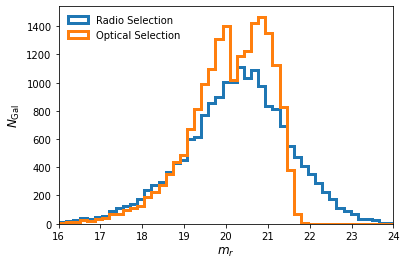

In [618]:
Fig, Ax = plt.subplots(1,1,figsize=(6,4))
Ax.hist(mag_r[mightee_selection], bins=50, histtype='step', lw=3, label='Radio Selection', range=(15.5, 24))
Ax.hist(mag_r[optical_selection], bins=50, histtype='step', lw=3, label='Optical Selection', range=(15.5, 24))
Leg = Ax.legend(loc='upper left', frameon=False)
Ax.set_xlabel(r'$m_{r}$', size=12)
Ax.set_ylabel(r'$N_{\rm{Gal}}$', size=12)
Ax.set_xlim([16., 24.])
Fig.savefig('orchidss_wide_optical_magdist.pdf', format='pdf')

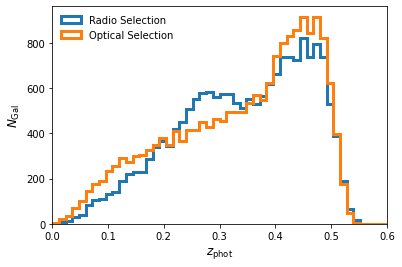

In [659]:
Fig, Ax = plt.subplots(1,1,figsize=(6,4))
Ax.hist(xmm_eazy_input['z_spec'][mightee_selection], bins=50, histtype='step', lw=3, label='Radio Selection', range=(0., 0.6))
Ax.hist(xmm_eazy_input['z_spec'][optical_selection], bins=50, histtype='step', lw=3, label='Optical Selection', range=(0., 0.6))
Leg = Ax.legend(loc='upper left', frameon=False)
Ax.set_xlabel(r'$z_{\rm{phot}}$', size=12)
Ax.set_ylabel(r'$N_{\rm{Gal}}$', size=12)
Ax.set_xlim([0., 0.6])
Fig.savefig('orchidss_wide_optical_zdist.pdf', format='pdf')

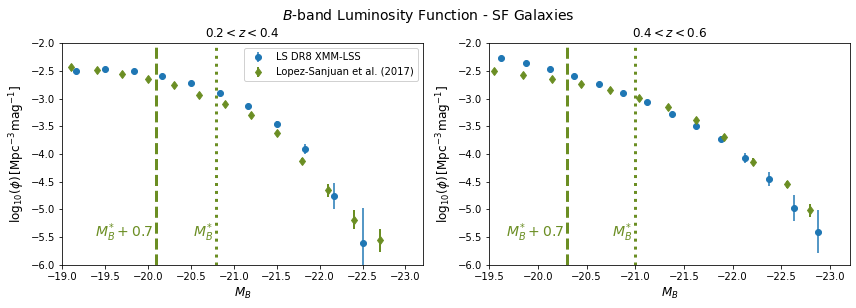

In [619]:
zbin = (xmm_merged['zphot'] > 0.2) * (xmm_merged['zphot'] < 0.4)
volume = xmm_moc.sky_fraction * (cos.comoving_volume(0.4) - cos.comoving_volume(0.2))

lf_cut = in_mightee * zbin*np.invert(passive)*(xmm_merged['type']!='PSF')

counts, bins = np.histogram(Mb[lf_cut], range=[-23, -19], bins=12)

binmids = 0.5*(bins[:-1]+bins[1:])

xmm_nd = np.log10(counts/volume.value/np.diff(bins))
xmm_nderr = 2.5*np.log10(np.e)*(np.sqrt(counts)/counts)

# LS17
arr = np.array([line.split('\t') for line in ls_lf.split('\n')])
ls_binmids = -1*np.array([np.float32(d.strip('−')) for d in arr[:-6, 1]], dtype='float32')
ls_nd = -1*np.array([np.float32(d.split(' ± ')[0].strip('−')) for d in arr[:-6, 3]], dtype='float32')
ls_nderr = np.array([np.float32(d.split(' ± ')[1].strip('−')) for d in arr[:-6, 3]], dtype='float32')

Fig, Ax = plt.subplots(1, 2, figsize=(12, 4.5))

Ax[0].errorbar(binmids, xmm_nd, yerr=xmm_nderr, fmt='o', label='LS DR8 XMM-LSS')
Ax[0].errorbar(ls_binmids, ls_nd, yerr=ls_nderr, fmt='d', color='olivedrab', elinewidth=2, 
             label='Lopez-Sanjuan et al. (2017)')
#plt.yscale('log')
Ax[0].set_xlim([-19., -23.2])
Ax[0].set_ylim([-6, -2])
Ax[0].set_title('$0.2 < z < 0.4$', size=12)
Ax[0].set_xlabel(r'$M_{B}$', size=12)
Ax[0].set_ylabel(r'$\log_{10}(\phi)\/[\rm{Mpc}^{-3}\/\rm{mag}^{-1}$]', size=12)

Ax[0].vlines(-21 + -1.03*(0.3 - 0.5), ymax=-2, ymin=-6, ls=':', color='olivedrab', lw=3)
Ax[0].vlines(-21 + -1.03*(0.3 - 0.5)+0.7, ymax=-2, ymin=-6, ls='--', color='olivedrab', lw=3)
Ax[0].text(-21 + -1.03*(0.3 - 0.5)+0.03, -5.5, r'$M_{B}^{*}$', color='olivedrab', size=14, ha='right')
Ax[0].text(-21 + -1.03*(0.3 - 0.5)+0.73, -5.5, r'$M_{B}^{*}+0.7$', color='olivedrab', size=14, ha='right')

leg = Ax[0].legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)


### Bin 2
zbin = (xmm_merged['zphot'] > 0.4) * (xmm_merged['zphot'] < 0.6)
volume = xmm_moc.sky_fraction * (cos.comoving_volume(0.6) - cos.comoving_volume(0.4))

lf_cut = in_mightee * zbin*np.invert(passive)*(xmm_merged['type']!='PSF')

counts, bins = np.histogram(Mb[lf_cut], range=[-23, -19.5], bins=14)

xmm_nd = np.log10(counts/volume.value/np.diff(bins))
xmm_nderr = 2.5*np.log10(np.e)*(np.sqrt(counts)/counts)

binmids = 0.5*(bins[:-1]+bins[1:])

# LS17
arr = np.array([line.split('\t') for line in ls_lf.split('\n')])
ls_binmids = -1*np.array([np.float32(d.strip('−')) for d in arr[:-6, 2]], dtype='float32')
ls_nd = -1*np.array([np.float32(d.split(' ± ')[0].strip('−')) for d in arr[:-6, 5]], dtype='float32')
ls_nderr = np.array([np.float32(d.split(' ± ')[1].strip('−')) for d in arr[:-6, 5]], dtype='float32')

Ax[1].errorbar(binmids, xmm_nd, yerr=xmm_nderr, fmt='o', label='LS DR8 XMM-LSS')
Ax[1].errorbar(ls_binmids, ls_nd, yerr=ls_nderr, fmt='d', color='olivedrab', 
             elinewidth=2, label='Lopez-Sanjuan et al. (2017)')

#plt.yscale('log')
Ax[1].set_xlim([-19.5, -23.2])
Ax[1].set_ylim([-6, -2])
Ax[1].set_title('$0.4 < z < 0.6$', size=12)
Ax[1].set_xlabel(r'$M_{B}$', size=12)
Ax[1].set_ylabel(r'$\log_{10}(\phi)\/[\rm{Mpc}^{-3}\/\rm{mag}^{-1}$]', size=12)

Ax[1].vlines(-21 + -1.03*(0.5 - 0.5), ymax=-2, ymin=-6, ls=':', color='olivedrab', lw=3)
Ax[1].vlines(-21 + -1.03*(0.5 - 0.5)+0.7, ymax=-2, ymin=-6, ls='--', color='olivedrab', lw=3)
Ax[1].text(-21 + -1.03*(0.5 - 0.5)+0.03, -5.5, r'$M_{B}^{*}$', color='olivedrab', size=14, ha='right')
Ax[1].text(-21 + -1.03*(0.5 - 0.5)+0.73, -5.5, r'$M_{B}^{*}+0.7$', color='olivedrab', size=14, ha='right')

#leg = plt.legend(loc='lower left', frameon=False)
Fig.suptitle('$B$-band Luminosity Function - SF Galaxies', size=14, y=0.94)
Fig.tight_layout()
Fig.savefig('Bband_SF_LF_ls2017.pdf')

In [601]:
ls_lf = """−24.5	−23.0	−23.29	−7.05 ± 0.34	−23.42	−6.39 ± 0.26	−23.20	−5.75 ± 0.14	−23.34	−5.45 ± 0.09
            −23.0	−22.7	−22.79	−5.56 ± 0.21	−22.81	−5.02 ± 0.11	−22.82	−4.64 ± 0.06	−22.83	−4.44 ± 0.05
            −22.7	−22.4	−22.56	−5.19 ± 0.17	−22.54	−4.55 ± 0.07	−22.52	−4.18 ± 0.05	−22.53	−3.99 ± 0.04
            −22.4	−22.1	−22.21	−4.66 ± 0.11	−22.22	−4.14 ± 0.06	−22.23	−3.83 ± 0.04	−22.23	−3.59 ± 0.03
            −22.1	−21.8	−21.91	−4.13 ± 0.06	−21.93	−3.70 ± 0.04	−21.93	−3.51 ± 0.03	−21.94	−3.27 ± 0.02
            −21.8	−21.5	−21.62	−3.63 ± 0.05	−21.63	−3.38 ± 0.03	−21.64	−3.23 ± 0.02	−21.64	−3.08 ± 0.02
            −21.5	−21.2	−21.34	−3.30 ± 0.04	−21.34	−3.15 ± 0.03	−21.34	−3.03 ± 0.02	−21.34	−2.90 ± 0.02
            −21.2	−20.9	−21.04	−3.10 ± 0.03	−21.04	−2.99 ± 0.02	−21.04	−2.87 ± 0.02	−21.04	−2.76 ± 0.01
            −20.9	−20.6	−20.74	−2.94 ± 0.03	−20.74	−2.85 ± 0.02	−20.74	−2.75 ± 0.02	−20.75	−2.64 ± 0.01
            −20.6	−20.3	−20.44	−2.76 ± 0.03	−20.45	−2.74 ± 0.02	−20.45	−2.65 ± 0.01	−20.45	−2.56 ± 0.01
            −20.3	−20.0	−20.15	−2.65 ± 0.02	−20.15	−2.65 ± 0.02	−20.15	−2.58 ± 0.01	−20.15	−2.47 ± 0.01
            −20.0	−19.7	−19.85	−2.56 ± 0.02	−19.84	−2.58 ± 0.02	−19.85	−2.50 ± 0.01	−19.85	−2.42 ± 0.01
            −19.7	−19.4	−19.55	−2.48 ± 0.02	−19.55	−2.50 ± 0.02	−19.55	−2.45 ± 0.01	−19.56	−2.36 ± 0.01
            −19.4	−19.1	−19.25	−2.43 ± 0.02	−19.25	−2.45 ± 0.01	−19.25	−2.41 ± 0.01	−19.27	−2.34 ± 0.02
            −19.1	−18.8	−18.95	−2.38 ± 0.02	−18.95	−2.39 ± 0.01	−18.95	−2.37 ± 0.01	−19.02	−2.30 ± 0.03
            −18.8	−18.5	−18.65	−2.32 ± 0.02	−18.65	−2.33 ± 0.01	−18.67	−2.37 ± 0.01	···	···
            −18.5	−18.2	−18.35	−2.27 ± 0.02	−18.35	−2.29 ± 0.01	−18.42	−2.34 ± 0.03	···	···
            −18.2	−17.9	−18.05	−2.22 ± 0.02	−18.06	−2.23 ± 0.02	···	···	···	···
            −17.9	−17.6	−17.75	−2.17 ± 0.02	−17.76	−2.18 ± 0.02	···	···	···	···
            −17.6	−17.3	−17.45	−2.12 ± 0.01	−17.49	−2.17 ± 0.03	···	···	···	···
            −17.3	−17.0	−17.16	−2.06 ± 0.02	···	···	···	···	···	···
            −17.0	−16.7	−16.86	−2.01 ± 0.02	···	···	···	···	···	···
            −16.7	−16.4	−16.56	−1.98 ± 0.02	···	···	···	···	···	···
            −16.4	−16.1	−16.26	−1.92 ± 0.03	···	···	···	···	···	···
            −16.1	−15.8	−15.97	−1.87 ± 0.04	···	···	···	···	···	···
            −15.8	−15.5	−15.69	−1.83 ± 0.07	···	···	···	···	···	···"""

In [ ]:
from skyavoidance import *

def simple_tycho_query(coords, radius):
    """ Query the Tycho-2 star catalogue for sources within a region

    Parameters
    ----------
    coords : `~astropy.coordinates.SkyCoord`
        Coordinates of field centre for Tycho-2 source query

    Returns
    -------
    table : `astropy.table.Table`
        Results of database query
    """

    table = ESASky.query_region_catalogs(coords, radius, catalogs=['Tycho-2'])[0]
    return table

def simple_2mass_xsc_query(coords, radius, cols=['ra','dec','r_k20fe','r_ext','cc_flg']):
    """ Query the 2MASS Extended Source Catalog for sources within a region

    Parameters
    ----------
    coords : `~astropy.coordinates.SkyCoord`
        Coordinates of field centre for Gaia source query

    cols : list
        Requested 2MASS XSC columns for database query. Default list inclues
        those potentially required for WEAVE avoidance list generation.

    Returns
    -------
    table : `astropy.table.Table`
        Results of database query
    """

    xsc_cols = cols
    table = Irsa.query_region(coords, catalog="fp_xsc",
                              spatial="Cone", radius=radius,
                              selcols=','.join(xsc_cols))

    good = (table['cc_flg'] == '0')
    return table[good]

def simple_2mass_lga_query(coords, radius, cols=['ra','dec','r_k20fe','r_ext']):
    """ Query the 2MASS Large Galaxy Atlas for sources within a region

    Parameters
    ----------
    coords : `~astropy.coordinates.SkyCoord`
        Coordinates of field centre for Gaia source query

    cols : list
        Requested 2MASS LGA columns for database query. Default list inclues
        those potentially required for WEAVE avoidance list generation.

    Returns
    -------
    table : `astropy.table.Table`
        Results of database query
    """
    lga_cols = cols
    table = Irsa.query_region(coords, catalog="lga_v2",
                              spatial="Cone", radius=radius,
                              selcols=','.join(lga_cols))
    return table

def gen_mask(ra, dec, radius, gaia=True, tycho=True,
             twomass=True, lga=True,
             maglim=16, radius_scale=1):
    """ Construct combined sky avoidance list for WEAVE MOS OBs

    Parameters
    ----------
    ra :
    
    dec : 
    
    radius : 
    
    gaia : bool
        Include GAIA DR3 sources in avoidance list (default = True)
    tycho : bool
        Include Tycho-2 sources in avoidance list (default = True)
    twomass : bool
        Include 2MASS XSC sources in avoidance list (default = True)
    lga : bool
        Include 2MASS LGA sources in avoidance list (default = True)
    maglim : float
        Faint magnitude limit for Gaia source search (default = 16)
    radius_scale : float
        Multiplicative factor used to scale magnitude dependent avoidance
        radii for GAIA and Tycho-2 stars

    Returns
    -------
    merged : `~astropy.table.Table`
        Combined list of avoidance region positions and radii
    """

    field_coords = SkyCoord(ra, dec, unit='deg')
    radius = u.Quantity(radius, u.deg)

    table_list = []

#     if gaia:
#         gaia_table = simple_gaia_query(field_coords, maglim, radius=radius)
#         if len(gaia_table) > 0:
#             out_table = Table()
#             out_table['ra'] = gaia_table['ra']
#             out_table['dec'] = gaia_table['dec']
#             out_table['radius'] = ((694.7 * np.exp(gaia_table['phot_g_mean_mag']/-4.04))) * radius_scale
#             table_list.append(out_table)

    if tycho:
        tycho_table = simple_tycho_query(field_coords, radius=radius)
        if len(tycho_table) > 0:
            out_table = Table()
            out_table['ra'] = tycho_table['ra']
            out_table['dec'] = tycho_table['dec']
            out_table['radius'] = ((694.7 * np.exp(tycho_table['vt_mag']/-4.04))) * radius_scale
            table_list.append(out_table)

    if twomass:
        xsc_table = simple_2mass_xsc_query(field_coords, radius=radius)
        if len(xsc_table) > 0:
            out_table = Table()
            out_table['ra'] = xsc_table['ra']
            out_table['dec'] = xsc_table['dec']
            out_table['radius'] = xsc_table['r_ext']
            table_list.append(out_table)

    if lga:
        lga_table = simple_2mass_lga_query(field_coords, radius=radius)
        if len(lga_table) > 0:
            out_table = Table()
            out_table['ra'] = lga_table['ra']
            out_table['dec'] = lga_table['dec']
            out_table['radius'] = lga_table['r_ext']
            table_list.append(out_table)

    merged = vstack(table_list)
    return merged

for row in mask_list[:1]:
    m = MOC.from_cone(row['ra']*u.deg, row['dec']*u.deg, 
                      radius=row['radius']*u.arcsec, max_depth=16)
    
mightee = Table.read('../InputCatalogues/radio/mightee_pointings.txt', format='ascii.commented_header')
mightee_pointing_coord = SkyCoord(mightee['RA'], mightee['DEC'], unit='deg')

xmm = np.array([row['POINTING'].startswith('XMMLSS') for row in mightee])

masks = []
for coord in tqdm(mightee_pointing_coord[xmm]):
    mask_list = gen_mask(coord.ra, 
                         coord.dec, 
                         1*u.deg, maglim=14, twomass=False, radius_scale=0.3)
    
    masks.append(mask_list)
    
masks = vstack(masks)

uid = [f'{row["ra"]}_{row["dec"]}_{row["radius"]}' for row in masks]
_, unique_idx = np.unique(uid, return_index=True)

mask_cat = masks[unique_idx] 

mask_mocs = [MOC.from_cone(row['ra']*u.deg, row['dec']*u.deg, row['radius']*u.arcsec, max_depth=16) for row in mask_cat]
mask_moc = mask_mocs[0]
for i in range(len(mask_mocs)-1):
    mask_moc = mask_moc.union(mask_mocs[i+1])
    
fig = plt.figure(figsize=(7,7))

wcs = mask_moc.wcs(fig)  # automatically creates a wcs for the MOC
ax1 = fig.add_subplot(111, projection=wcs)  # The first of a 2*2 grig of subplots
mask_moc.fill(
    ax1,
    wcs,
    color="hotpink",
    alpha=0.5,
)  # Where the MOC is added to the plot
ax1.set_title("A convexe MOC")